In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
import pickle


In [ ]:
# import pandas as pd
# from google.colab import files

# # Upload the dataset
# uploaded = files.upload()

# # Get the uploaded file name
# file_name = list(uploaded.keys())[0]

# # Load the dataset
# data = pd.read_csv(file_name)

# # Define the selected columns
# selected_columns = [
#     'stddev_2_a', 'min_2_a', 'min_q_2_a', 'min_q_7_a', 'min_q_12_a', 'min_q_17_a',
#     'covmat_104_a', 'logm_9_a', 'entropy0_a', 'entropy3_a', 'stddev_2_b', 'min_2_b',
#     'min_q_2_b', 'min_q_7_b', 'min_q_12_b', 'min_q_17_b', 'covmat_104_b',
#     'logm_9_b', 'entropy0_b', 'entropy3_b', 'label'
# ]

# # Filter only the required columns
# filtered_data = data[selected_columns]

# # Save the filtered dataset to a CSV file
# filtered_file_name = 'filtered_dataset.csv'
# filtered_data.to_csv(filtered_file_name, index=False)

# # Download the filtered dataset
# files.download(filtered_file_name)


Saving emotions.csv to emotions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
import pandas as pd
# Upload the dataset (upload manually or from Kaggle)
uploaded = files.upload()

# Get the uploaded file name
file_name = list(uploaded.keys())[0]

# Load the dataset
data = pd.read_csv(file_name)
data.head()


Saving emotions.csv to emotions (1).csv


,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


In [ ]:
# Drop missing values
data.dropna(inplace=True)


In [ ]:
# Encode target variable
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

# Save the label encoder for inference
with open('label_encoder_final.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)


In [ ]:
# Separate features and target
X = data.drop('label', axis=1)
y = data['label']


In [ ]:
# Select top 20 important features using ANOVA F-statistic
selector = SelectKBest(score_func=f_classif, k=20)
X_selected = selector.fit_transform(X, y)

# Get the selected feature names
selected_features = X.columns[selector.get_support()]
print(f"Top 20 selected features: {selected_features.tolist()}")


Top 20 selected features: ['stddev_2_a', 'min_2_a', 'min_q_2_a', 'min_q_7_a', 'min_q_12_a', 'min_q_17_a', 'covmat_104_a', 'logm_9_a', 'entropy0_a', 'entropy3_a', 'stddev_2_b', 'min_2_b', 'min_q_2_b', 'min_q_7_b', 'min_q_12_b', 'min_q_17_b', 'covmat_104_b', 'logm_9_b', 'entropy0_b', 'entropy3_b']


In [ ]:
# Scale only the selected features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[selected_features])

# Save the scaler for future inference
with open('scaler_final.pkl', 'wb') as file:
    pickle.dump(scaler, file)


In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [ ]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU, Add, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

# Input layer
input_layer = Input(shape=(X_train.shape[1],))

# First Dense Block
x = Dense(128, kernel_regularizer=l2(0.001))(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)

# Second Dense Block
x = Dense(64, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)

# Residual Connection Block (skip connection)
residual = Dense(64, kernel_regularizer=l2(0.001))(input_layer)  # Match shapes for addition
x = Add()([x, residual])
x = LeakyReLU()(x)

# Third Dense Block
x = Dense(32, kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)

# Output Layer
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 20)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │          2,688 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128)            │            512 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 128)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64)             │            256 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 64)             │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          1,344 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64)             │              0 │ dropout_1[0][0],       │
│                           │                        │                │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 64)             │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │          2,080 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32)             │            128 │ dense_3[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 32)             │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32)             │              0 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 3)              │             99 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,363 (60.01 KB)

 Trainable params: 14,915 (58.26 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2)


Epoch 1/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9065 - loss: 0.2726 - val_accuracy: 0.8974 - val_loss: 0.3033
Epoch 2/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8861 - loss: 0.3269 - val_accuracy: 0.9120 - val_loss: 0.2649
Epoch 3/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8934 - loss: 0.2991 - val_accuracy: 0.9032 - val_loss: 0.2796
Epoch 4/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8860 - loss: 0.3063 - val_accuracy: 0.8944 - val_loss: 0.2648
Epoch 5/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8796 - loss: 0.3078 - val_accuracy: 0.9032 - val_loss: 0.2782
Epoch 6/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8876 - loss: 0.3079 - val_accuracy: 0.8974 - val_loss: 0.2827
Epoch 7/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9085 - loss: 0.2810 - val_accuracy: 0.8974 - val_loss: 0.2636
Epoch 8/200
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9002 - loss: 0.2771 - val_accuracy: 0.9

In [ ]:
# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Accuracy and Classification Report
print("Accuracy Score:", accuracy_score(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy Score: 0.8548009367681498
              precision    recall  f1-score   support

    NEGATIVE       0.87      0.99      0.92       143
     NEUTRAL       1.00      0.74      0.85       148
    POSITIVE       0.74      0.84      0.79       136

    accuracy                           0.85       427
   macro avg       0.87      0.86      0.85       427
weighted avg       0.87      0.85      0.85       427



14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


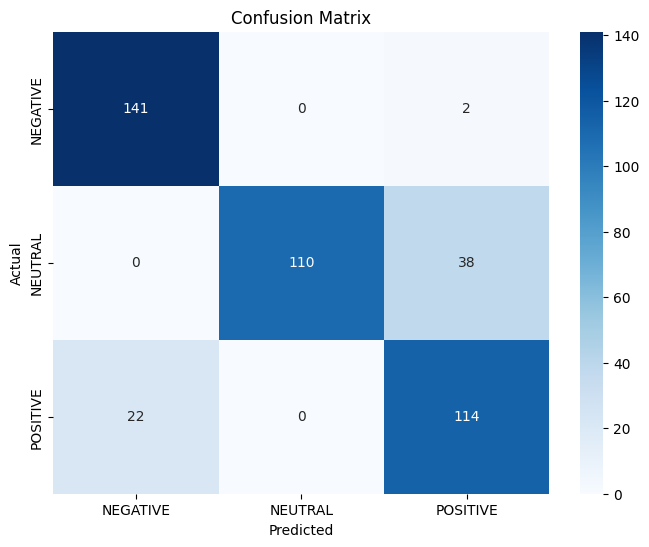

              precision    recall  f1-score   support

    NEGATIVE       0.87      0.99      0.92       143
     NEUTRAL       1.00      0.74      0.85       148
    POSITIVE       0.74      0.84      0.79       136

    accuracy                           0.85       427
   macro avg       0.87      0.86      0.85       427
weighted avg       0.87      0.85      0.85       427



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


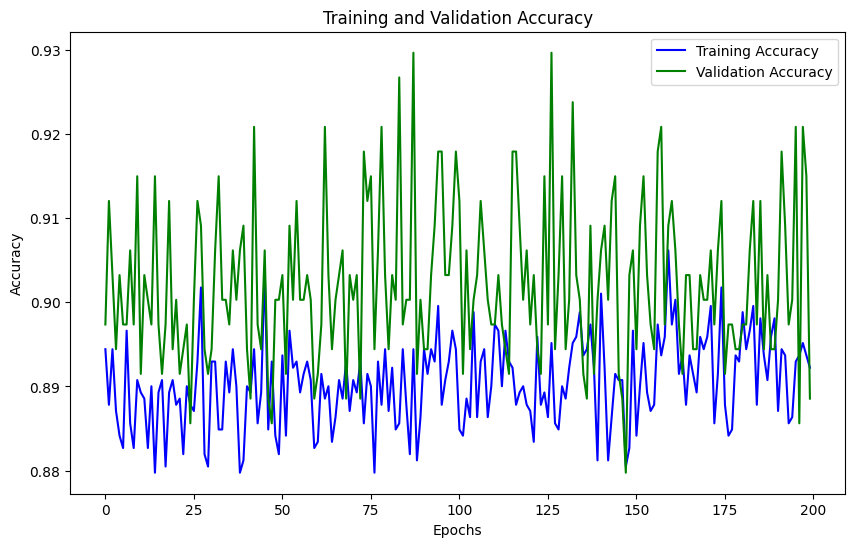

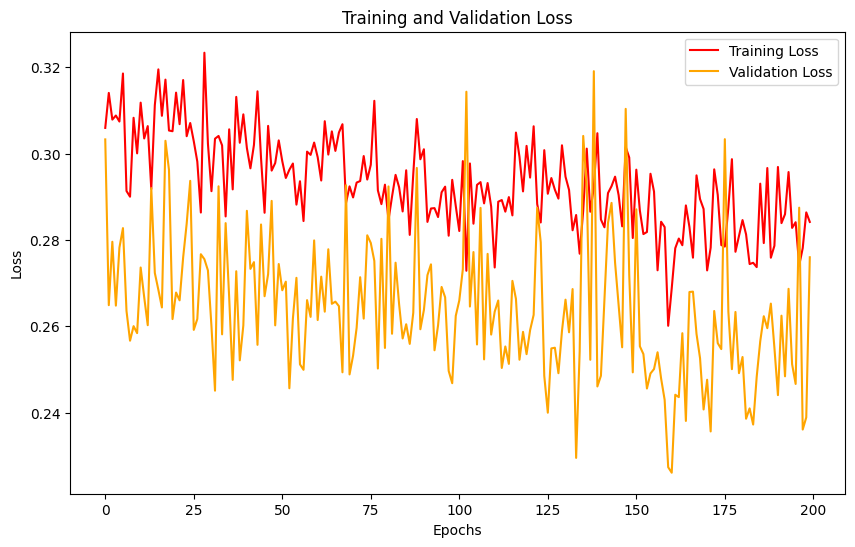

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


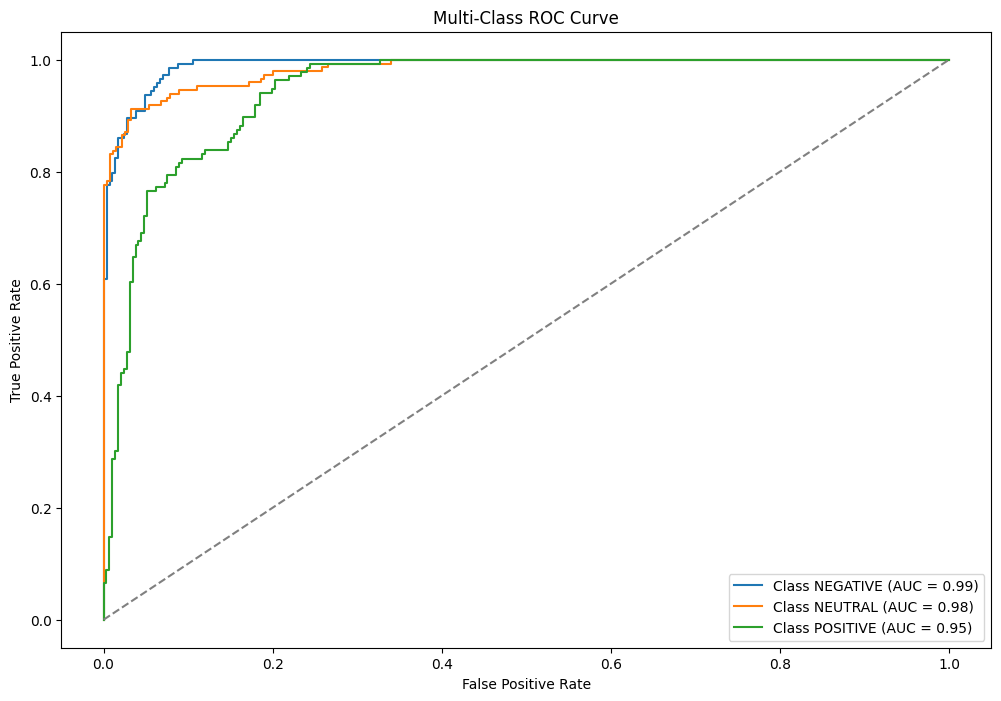

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels for multi-class ROC
n_classes = len(label_encoder.classes_)
y_test_bin = label_binarize(y_test, classes=[i for i in range(n_classes)])
y_pred_bin = y_pred

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.show()


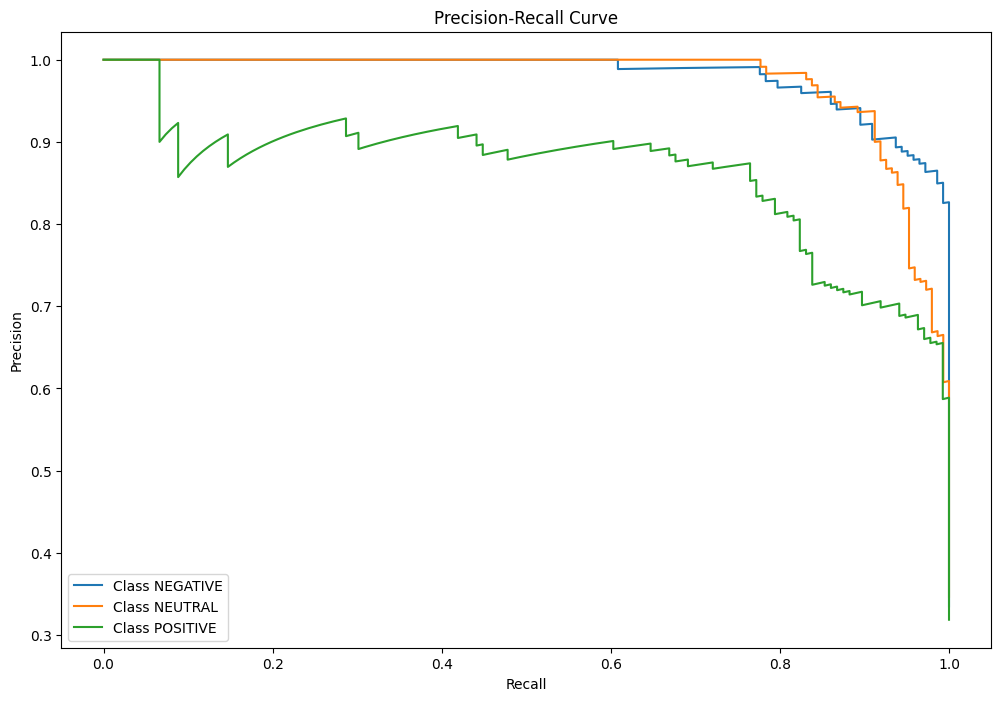

In [ ]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, label=f"Class {label_encoder.classes_[i]}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [ ]:
# Save the trained model
model.save('eeg_emotion_model_final.h5')
